<a href="https://colab.research.google.com/github/Jvlia17/deep-learning/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projekt ten ma na celu przeprowadzenie ataku aderwsarzowego metodą FGSM na głęboką sieć neuronową o architekturze typu ResNet (*Residual neural network*). W projekcie sprawdzony zostanie wpływ parametru ɛ metody FGSM. W celu przeprowadzenia eksperymentów, zostanie wytrenowana sieć ResNet na zbiorze CIFAR-10. Zostanie sprawdzona metoda obrony przed takimi atakami, tj. dodanie rozmycia do obrazu wejściowego.

Na początku zatem należy stworzyć model. Architektura modelu została zaimplementowana na podstawie [[1]](https://arxiv.org/pdf/1512.03385.pdf) oraz [[2]](https://github.com/akamaster/pytorch_resnet_cifar10). Zaimplementowano model o 110 warstwach, ResNet110, jako że jak podaje [[1]](https://arxiv.org/pdf/1512.03385.pdf), otrzymano na nim najmniejszy błąd dla zbioru CIFAR10.

https://github.com/akamaster/pytorch_resnet_cifar10

https://arxiv.org/pdf/1512.03385.pdf

https://medium.com/analytics-vidhya/resnet-10f4ef1b9d4c

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0

https://www.kaggle.com/code/banerz/resnet-implementation-in-pytorch

https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/



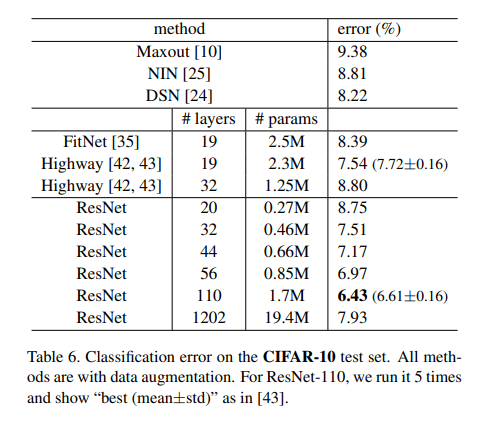

*We follow the simple data augmentation in [24] for training: 4 pixels are padded on each side,
and a 32×32 crop is randomly sampled from the padded
image or its horizontal flip. For testing, we only evaluate
the single view of the original 32×32 image.*

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=e1884bf5be0832cfd98d4207eccb78b186bd6bc03f8d1a8074f79d3a6adf4445
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
# from torchviz import make_dot
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super().__init__()
        self.inplanes = 16
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(16),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 16, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 32, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 64, layers[2], stride = 2)
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = F.avg_pool2d(x, x.size()[3])
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

model = ResNet(ResidualBlock, [18,18,18]).to(device)

summary(model, (3, 32, 32))

# x = torch.randn(1,3,32, 32)
# y = model(x)

# make_dot(y.mean(), params=dict(model.named_parameters())).render("rnn_torchviz", format="png")


'rnn_torchviz.png'

Wczytanie zbioru danych:

In [46]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [65]:
classes = trainset.classes
print(classes)
# calculate mean and std for the dataset
imgs_train = torch.stack([img_t for img_t ,_ in trainset],dim=3)
imgs_test = torch.stack([img_t for img_t ,_ in testset],dim=3)
imgs = torch.cat((imgs_train, imgs_test), 3)
mean = imgs.view(3,-1).mean(dim=1).numpy()
std = imgs.view(3, -1).std(dim=1).numpy()
print(mean, std)

normalize= transforms.Normalize(mean=[mean[0], mean[1], mean[2]],
                                     std=[std[0], std[1], std[2]])

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([3, 32, 32, 50000]) torch.Size([3, 32, 32, 10000])
torch.Size([3, 32, 32, 60000])
[0.49186882 0.48265398 0.44717732] [0.24697122 0.24338895 0.2615926 ]


In [76]:
# data augmentation: 4 pixels are padded on each side,
# and a 32×32 crop is randomly sampled from the padded
# image or its horizontal flip

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=batch_size, shuffle=True, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


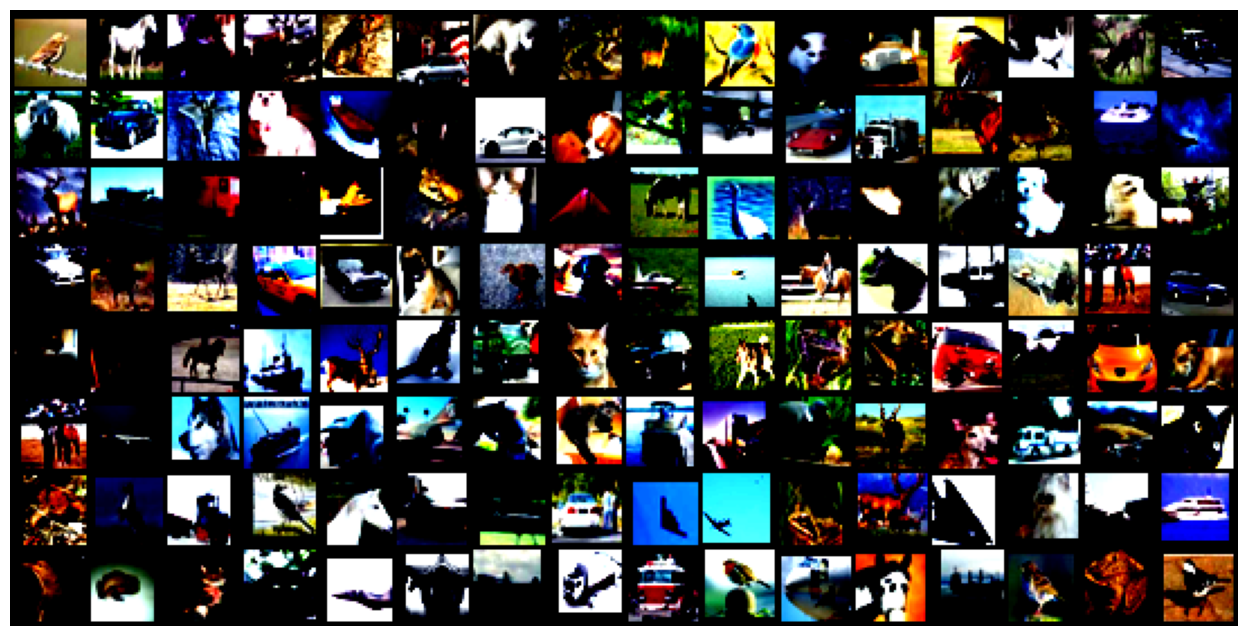

In [77]:
for images, _ in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [69]:
# Hyper-parameters
num_epochs = 200
batch_size = 128
learning_rate = 0.001
weight_decay = 0.0001 # ??
momentum = 0.9
# when the training error is below 80% go to lr=0.1